## Tutorial: **Estimating heads rate of a coin**

This tutorial demonstrates modeling and running inference on a simple coin-flipping
model in Bean Machine. This should offer an accessible introduction to fundamental
features of Bean Machine.

## Problem

In this tutorial, we consider the problem of estimating the probability of heads for a
potentially biased coin. In this setup, we have flipped the coin a few times and
recorded the results as training data. We're interested in better understanding the coin's
true heads rate.

## Prerequisites

Let's code this in Bean Machine! Import the Bean Machine library and some fundamental
PyTorch classes.

In [1]:
# Install Bean Machine in Colab if using Colab.
import sys


if "google.colab" in sys.modules and "beanmachine" not in sys.modules:
    !pip install beanmachine

In [2]:
import os

import arviz as az
import beanmachine.ppl as bm
import beanmachine.ppl.inference.monte_carlo_samples
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.distributions as dist
from beanmachine.tutorials.utils import plots
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Colorblind3
from bokeh.plotting import gridplot, show
from IPython.display import Markdown
from torch import tensor

The next cell includes convenient configuration settings to improve the notebook
presentation as well as setting a manual seed for reproducibility.

In [3]:
# Plotting settings
plt.rc("figure", figsize=[8, 6])
plt.rc("font", size=14)
plt.rc("lines", linewidth=2.5)

# Manual seed
bm.seed(11)
torch.manual_seed(11)

# Other settings for the notebook.
smoke_test = "SANDCASTLE_NEXUS" in os.environ or "CI" in os.environ

# Plotting settings
az.rcParams["plot.backend"] = "bokeh"
az.rcParams["stats.hdi_prob"] = 0.89

## Model

We have the following definitions.

* $\theta \in [0, 1]$: Heads rate of the coin.
* $y_i \in \{0, 1\}$: Result of the $i$th coin flip. This is usually an observed value.
* $N \in \mathbb{Z}^+$: Number of observed coin flips.

We're interested in modeling:

* $\mathbb{P}(\theta | \{y_i\}_{i=1}^N)$

In Bayesian modeling, we encode our initial understanding of $\theta$ by specifying a
prior distribution for it $\mathbb{P}(\theta)$. We then describe the relationship
between the unobserved random variable $\theta$, and the observed random variables
$\{y_i\}_{i=1}^N$. We can do this as follows:

* $\theta \sim \text{Beta}(2, 2)$
* $y_i \stackrel{iid}{\sim} \text{Bernoulli}(\theta)$

These will later combine to form the posterior distribution $\mathbb{P}(\theta | \{y_i\}_{i=1}^N)$
which encodes our improved understanding of $\theta$.

As a convention, we will consider an outcome of 1 from the Bernoulli distribution to
represent heads and zero to represent tails. Here we chose to use a Beta distribution
for the prior distribution for the coin's probability of heads, but in principle any
distribution over $[0, 1]$ can be used.

Let's visualize the particular Beta distribution used in this tutorial:

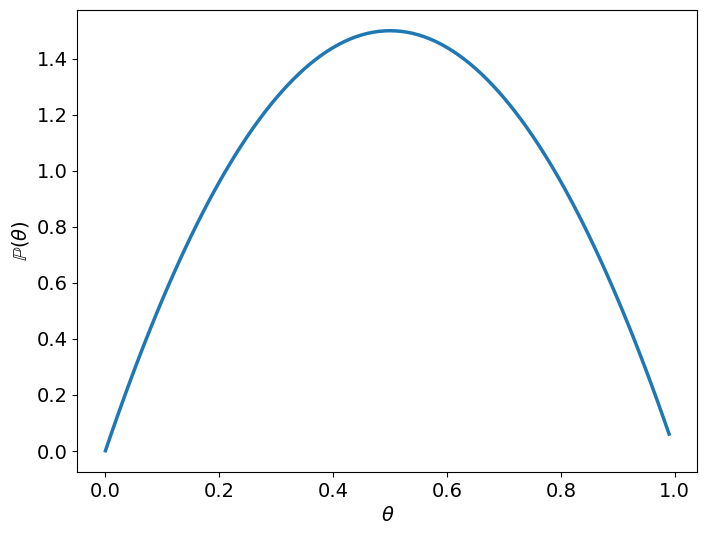

In [4]:
thetas = torch.arange(0, 1, 0.01)
plt.plot(thetas, dist.Beta(2, 2).log_prob(thetas).exp())
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{P}(\theta)$");

We can implement this model in Bean Machine by defining random variable objects with the
`@bm.random_variable` decorator. These functions behave differently than ordinary Python
functions.

<div
  style="background: #daeaf3;
      border_left: 3px solid #2980b9;
      display: block;
      margin: 16px 0;
      padding: 12px;"
>
  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>
      They must return PyTorch <code>Distribution</code> objects.
    </li>
    <li>
      Though they return distributions, callees actually receive a <i>sample</i> from
      the distribution. The machinery for obtaining samples from distributions is
      handled internally by Bean Machine.
    </li>
    <li>
      Inference runs the model through many iterations. During a particular inference
      iteration, a distinct random variable will correspond to exactly one sampled
      value: <b>calls to the same random variable function with the same arguments will
      receive the same sampled value within one inference iteration</b>. This makes it
      easy for multiple components of your model to refer to the same logical random
      variable.
    </li>
    <li>
      Consequently, to define distinct random variables that correspond to different
      sampled values during a particular inference iteration, an effective practice is
      to add a dummy "indexing" parameter to the function. Distinct random variables can
      be referred to with different values for this index.
    </li>
      <li>
        Please see the documentation for more information about this decorator.
      </li>
  </ul>

  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>
      This is a decorator that let's you treat deterministic code as if it's a Bean
      Machine random variable. This is used to transform the results of one or more
      random variables.
    </li>
    <li>
      This follows the same naming practice as <code>@bm.random_variable</code> where
      variables are distinguished by their argument call values.
    </li>
  </ul>
</div>

First, let's define our prior for the heads rate, $\theta$, using this syntax:

In [5]:
@bm.random_variable
def theta():
    return dist.Beta(2, 2)

Similarly, let's define a random variables for the observed values, $y_i$:

In [6]:
@bm.random_variable
def y(i: int):
    return dist.Bernoulli(theta())

The mathematical definitions map directly to the Python definitions.

In contrast to `theta()`, notice that `y(i)` defines a dummy indexing parameter `i`.
That's because `y(i)` is actually defining a _family_ of random variables -- one for
each observed coin flip! This allows us to refer to specific observations as `y(0)`,
`y(1)`, and so on.

In the above examples, we've defined our random variable functions in the toplevel for
convenience. It's worth noting that Bean Machine models can be packaged into Python
classes and instantiated as needed. This essentially namespaces random variables defined
within, since the `self` argument that each random variable receives will be associated
with the distinct instantiated class that it's a part of. Example code is included as an
illustration below; however, this tutorial will continue to use the toplevel
definitions.

In [7]:
class HeadsRateModel(object):
    @bm.random_variable
    def theta(self):
        return dist.Beta(2, 2)

    @bm.random_variable
    def y(self, i):
        return dist.Bernoulli(self.theta())


heads_rate_model = HeadsRateModel()

## Data

With the model defined, we need to collect some observed data in order to learn about
values of interest in our model.

In this case, we will observe a few coin flips. For demonstrative purposes, we will use
a synthetically generated dataset of observed values. In practice, you would flip a real
coin and record observations instead.

For our synthetic dataset, we will assume a true heads rate of $0.75$:

In [8]:
true_theta = 0.75
true_y = dist.Bernoulli(true_theta)

Now, we'll gather $10$ observations from flipping that coin.

In [9]:
N = 10
y_obs = true_y.sample((N,))

In [10]:
y_obs[0]

tensor(1.)

Let's analyze the dataset:

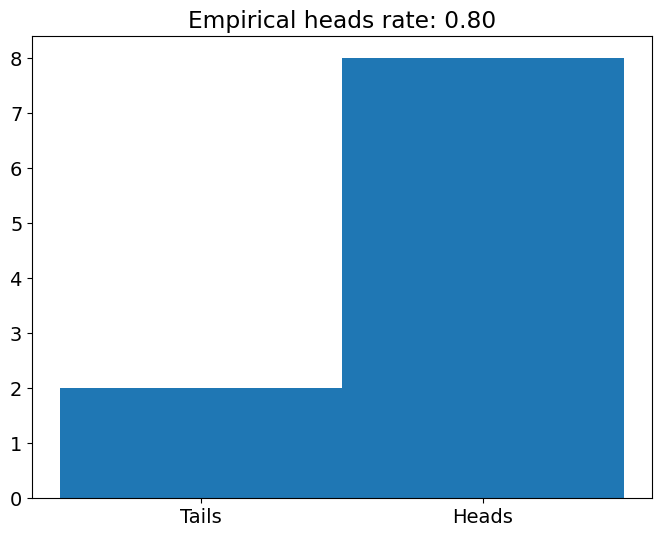

In [11]:
plt.hist(y_obs.numpy(), bins=2)
plt.xticks([0.25, 0.75], ["Tails", "Heads"])
plt.title(f"Empirical heads rate: {y_obs.mean() :.2f}");

## Inference

Inference is the process of combining _model_ and _data_ to obtain _insights_, in the
form of probability distributions over values of interest. Bean Machine offers a
powerful and general inference framework to enable fitting a arbitrary models to data.

Our inference algorithms expect observations in the form of a dictionary. This
dictionary should consist of `@bm.random_variable` invocations as keys, and tensor data
as values. You can see this in the example below:

In [12]:
observations = {
    y(0): y_obs[0],
    y(1): y_obs[1],
    y(2): y_obs[2],
    y(3): y_obs[3],
    y(4): y_obs[4],
    y(5): y_obs[5],
    y(6): y_obs[6],
    y(7): y_obs[7],
    y(8): y_obs[8],
    y(9): y_obs[9],
}

Now, we're ready to run inference! For this very simple tutorial, we'll use the simple
Metropolis-Hastings inference algorithm. Check out the documentation or other tutorials
for more advanced examples!

Running inference consists of a few arguments:

| Name           | Usage                                                                                                    |
| -------------- | -------------------------------------------------------------------------------------------------------- |
| `queries`      | List of `@bm.random_variable` targets to fit posterior distributions for.                                |
| `observations` | A dictionary of observations.                                                                            |
| `num_samples`  | Number of Monte Carlo samples to approximate the posterior distributions for the variables in queries.   |
| `num_chains`   | Number of separate inference runs to use. Multiple chains can help verify that inference ran correctly.  |

Let's run inference:

In [13]:
num_samples = 2 if smoke_test else 1000

samples = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[theta()],
    observations=observations,
    num_samples=num_samples,
    num_chains=4,
)

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

## Analysis

`samples` now contains our inference results. Although we ran inference only to compute
distributions for `theta()`, in general you can compute distributions for many variables
at once. So, you have to index into this object using the random variable syntax we've
seen several times. Here's an example:

In [14]:
theta_for_four_chains = samples[theta()].detach()
theta_for_four_chains

tensor([[0.7710, 0.7710, 0.7710,  ..., 0.8267, 0.8267, 0.8086],
        [0.2854, 0.2854, 0.7474,  ..., 0.7243, 0.7243, 0.7865],
        [0.8248, 0.7088, 0.7088,  ..., 0.7886, 0.7886, 0.7886],
        [0.6676, 0.7408, 0.6948,  ..., 0.7648, 0.7648, 0.7648]])

Results from all four separate inference runs are stored in here. We'll use them later;
for now, let's just examine one of these runs:

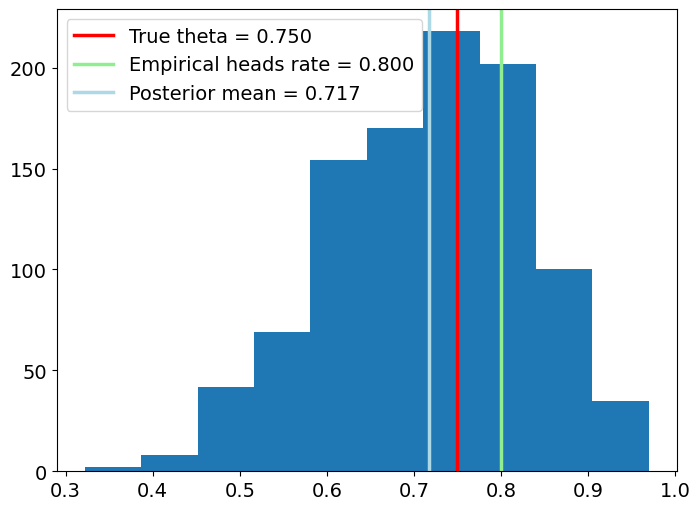

In [15]:
theta_for_first_chain = theta_for_four_chains[0]
plt.hist(theta_for_first_chain.numpy())
plt.axvline(true_theta, color="red", label=f"True theta = {true_theta :.03f}")
plt.axvline(
    y_obs.mean(),
    color="lightgreen",
    label=f"Empirical heads rate = {y_obs.mean() :.03f}",
)
plt.axvline(
    theta_for_first_chain.mean(),
    color="lightblue",
    label=f"Posterior mean = {theta_for_first_chain.mean() :.03f}",
)
plt.legend();

The graph above is based on pseudo-randomly generated data, so, the results can be
varied by changing the seed. Typically, <!--
  the true $\theta$ will remain within the main non-zero probability part of the
  histogram, but may not necessarily fall in the modal interval of the histogram. More
  generally, for this particular problem, we can expect
--> the mean of inferred distribution will be closer to 0.5 than the true $\theta$. This
is because 0.5 is the mean of our prior for $\theta$.

Arviz provides helpful statistics about the result of the inference algorithm. We can query this information as follows:

In [16]:
Markdown(az.summary(samples.to_inference_data(), round_to=4).to_markdown())

|         |   mean |     sd |   hdi_5.5% |   hdi_94.5% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |
|:--------|-------:|-------:|-----------:|------------:|------------:|----------:|-----------:|-----------:|--------:|
| theta() | 0.7161 | 0.1154 |     0.5527 |      0.9035 |      0.0036 |    0.0025 |     1051.7 |    914.083 |   1.006 |

As is suggested by the visualization, the average and the median are around $0.72$. Moreover, 95% of the samples fall within the interval $[0.460, 0.904]$. The width of this interval reflects the reality that we have conditions on few observations, and so should be quite uncertain about the true $\theta$.

As is suggested by the visualization, the average and the median are around $0.72$.
Moreover, 95% of the samples fall within the interval $[0.460, 0.904]$. The width of
this interval reflects the reality that we have conditions on few observations, and so
should be quite uncertain about the true $\theta$.

The summary output shows two diagnostic statistics:
[$\hat{R}$](https://projecteuclid.org/euclid.ss/1177011136) (`r_hat`) and
[$N_\text{eff}$](https://www.mcmchandbook.net/HandbookChapter1.pdf) (effective sample
size, `n_eff`).

* $\hat{R} \in [1, \infty)$ summarizes how effective inference was at converging on
  the correct posterior distribution for a particular random variable. It uses
  information from all chains run in order to assess whether inference had a good
  understanding of the distribution or not. Values very close to zero indicate that all
  chains discovered similar distributions for a particular random variable. We do not
  recommend using inference results where $\hat{R} > 1.1$, as inference may not have
  converged. In that case, you may want to run inference for more samples.
* $N_\text{eff} \in [1, \texttt{num}\_\texttt{samples}]$ summarizes how independent
  posterior samples are from one another. Although inference was run for `num_samples`
  iterations, it's possible that those samples were very similar to each other (due to
  the way inference is implemented), and may not each be representative of the full
  posterior space. Larger numbers are better here, and if your particular use case calls
  for a certain number of samples to be considered, you should ensure that
  $N_\text{eff}$ is at least that large.

In this case, $\hat{R}$ and $N_\text{eff}$ seem to have acceptable values.


Bean Machine can also plot diagnostical information to assess model fit. Let's take a
look:

In [17]:
# Required for visualizing in Colab.
output_notebook(hide_banner=True)

samples_diagnostic_plots = gridplot(plots.plot_diagnostics(samples))
show(samples_diagnostic_plots)

The diagnostics output shows two diagnostic plots for individual random variables: trace
plots and autocorrelation plots.

* Trace plots are simply a time series of values assigned to random variables over each
  iteration of inference. The concrete values assigned are usually problem-specific.
  However, it's important that these values are "mixing" well over time. This means that
  they don't tend to get stuck in one region for large periods of time, and that each of
  the chains ends up exploring the same space as the other chains throughout the course
  of inference.
* Autocorrelation plots measure how predictive the last several samples are of the
  current sample. Autocorrelation may vary between -1.0 (deterministically
  anticorrelated) and 1.0 (deterministically correlated). (We compute autocorrelation
  approximately, so it may sometimes exceed these bounds.) In an ideal world, the
  current sample is chosen independently of the previous samples: an autocorrelation of
  zero. This is not possible in practice, due to stochastic noise and the mechanics of
  how inference works.

From the trace plots, we see each of the chains are healthy: they don't get stuck, and
do not explore a chain-specific subset of the space. From the autocorrelation plots, we
see the absolute magnitude of autocorrelation to be very small, often around 0.1,
indicating a healthy exploration of the space.

Bean Machine also has built in diagnostic tools that allow us to interactively explore
our `samples` object. Select the random variable `theta()` from the drop down menu to
explore an interactive plot of the kernel density estimate and cumulative distribution
for the selected random variable.


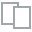
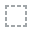
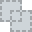
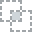
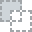
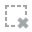
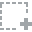
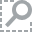
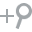
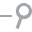
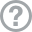
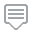
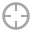
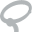
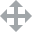
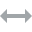
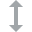
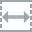
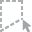
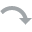
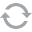
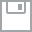
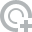
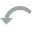
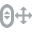
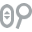
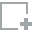
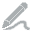
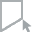
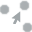
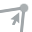
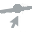

In [18]:
samples.diagnostics.marginal1d()

## BMGInference

Bean Machine Graph (BMG) Inference is an experimental feature of the Bean Machine
framework that aims to deliver higher performance for specialized models. The model used
in this tutorial represents a static probabilistic graph model and happens to use only
features within the language subset supported by `BMGInference`. Currently, however,
only Newtonian Monte Carlo (NMC) inference is supported by `BMGInference`. So, as a
reference point, the following code reports the time it takes for our basic
implementation of NMC to compute the posterior:

In [19]:
%%time
samples = bm.SingleSiteNewtonianMonteCarlo().infer(
    queries=[theta()],
    observations=observations,
    num_samples=num_samples,
    num_chains=4,
)

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 11 s, sys: 82 ms, total: 11.1 s
Wall time: 5.54 s


To run our model using `BMGInference`, the only change needed is the following:

In [20]:
%%time
from beanmachine.ppl.inference.bmg_inference import BMGInference

samples_bmg = BMGInference().infer(
    queries=[theta()],
    observations=observations,
    num_samples=num_samples,
    num_chains=4,
)

CPU times: user 468 ms, sys: 0 ns, total: 468 ms
Wall time: 459 ms

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


Wall time numbers will naturally vary on different platforms, but with with these
parameters (model, observations, queries, sample size, and number of chains) speedup on
the author's machine is about 40x. Generally speaking, larger speedups are expected with
larger sample sizes. More information about `BMGInference` can be found on the website
in "Advanced" section of the documentation.